In [1]:
from graph import *
from models import *

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import plotly.graph_objects as go

In [3]:
scaling = pd.read_excel("wall time scaling.xlsx", sheet_name="Data")

In [4]:
fit_poly = lambda x, k3, k2, k1: k3 * x ** 3 + k2 * x ** 2 + k1 * x
k, cv = curve_fit(fit_poly, scaling["Size"], scaling["Wall Time"])
k_gpu, cv_gpu = curve_fit(fit_poly, scaling["Size"], scaling["Wall Time GPU"])

In [5]:
funcs = {"Global": lambda x: fit_poly(x, *k), "Intermediate": lambda x: x / 2.0e6}
funcs_gpu = {"Global": lambda x: fit_poly(x, *k_gpu), "Intermediate": lambda x: x / 2.0e6}

In [6]:
cms_run3  = graph_from_spreadsheet("cms_system_60.xlsx", funcs)

In [7]:
list(cms_run3.successors("Inner Tracker"))

['Tracking']

In [8]:
list(nx.dfs_postorder_nodes(cms_run3, "Inner Tracker"))

['Disk', 'Global', 'Intermediate', 'Tracking', 'Inner Tracker']

In [9]:
cms_run3.nodes["Inner Tracker"]

{'sample data': 436666.6666666666,
 'sample rate': 40000000,
 'type': 'detector',
 'op efficiency': 0,
 'classifier': <statistics.DummyClassifier at 0x292cde2f0>,
 'error matrix': array([[0., 0.],
        [1., 1.]]),
 'rejection ratio': 1.0,
 'data reduction': 1.0,
 'complexity': <function graph.detectors.<locals>.<lambda>(x)>,
 'global ratio': 40000.0,
 'message size': 436666.6666666666,
 'ops': 436666.6666666666,
 'discards': array([0, 0])}

In [10]:
cms_run3.nodes["Intermediate"]

{'classifier': <statistics.Classifier at 0x292d5b550>,
 'error matrix': array([[0.99873122, 0.50751051],
        [0.00126878, 0.49248949]]),
 'type': 'processor',
 'rejection ratio': 400,
 'data reduction': 1.0,
 'op efficiency': 0.003,
 'sample data': 260000,
 'complexity': <function __main__.<lambda>(x)>,
 'global ratio': 40000,
 'message size': 2000666.6666666667,
 'ops': 1.0003333333333333,
 'contingency': array([[3.99482502e+07, 5.07510505e+02],
        [5.07497827e+04, 4.92489495e+02]]),
 'discards': array([3.99482502e+07, 5.07510505e+02])}

In [11]:
i_n = cms_run3.nodes["Intermediate"]

In [12]:
emi = i_n["error matrix"]

In [13]:
graph = cms_run3

In [14]:
previous = list(graph.predecessors("Intermediate"))
n_previous = len(previous)

In [15]:
#collect statistics over inputs
statistics = [propagate_statistics(graph, n) for n in previous]

In [16]:
statistics

[array([3.9999e+07, 1.0000e+03]),
 array([3.9999e+07, 1.0000e+03]),
 array([3.9999e+07, 1.0000e+03]),
 array([3.9999e+07, 1.0000e+03])]

In [17]:
#take the average over the input nodes to collate inputs into a single file
statistics2 = functools.reduce(lambda x, y: x + y, statistics) / n_previous

In [18]:
statistics2

array([3.9999e+07, 1.0000e+03])

In [19]:
statistics2 * emi == i_n["contingency"]

array([[ True,  True],
       [ True,  True]])

In [20]:
np.sum(emi, axis=0)

array([1., 1.])

In [21]:
i_n["contingency"]

array([[3.99482502e+07, 5.07510505e+02],
       [5.07497827e+04, 4.92489495e+02]])

In [22]:
np.sum(get_rejected(i_n["contingency"])) 

39948757.72781946

In [23]:
np.sum(get_passed(i_n["contingency"]))

51242.27218054543

In [24]:
np.sum(get_rejected(i_n["contingency"])) + np.sum(get_passed(i_n["contingency"]))

40000000.0

In [25]:
np.sum(get_rejected(i_n["contingency"])) / np.sum(get_passed(i_n["contingency"]))

779.6055098233203

In [26]:
inc = i_n["classifier"]

In [27]:
xs = np.linspace(-3.0, 6.0, 101)

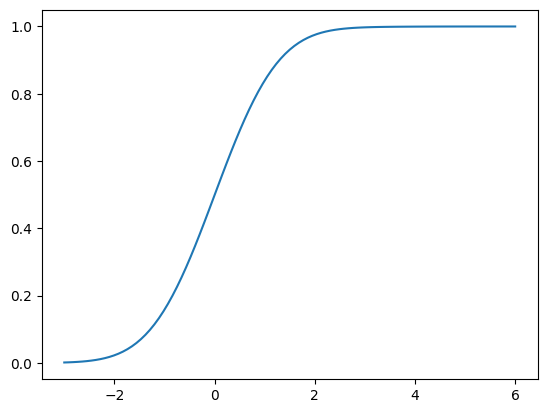

In [28]:
plt.plot(xs, inc.scores(xs))

In [29]:
xs = np.linspace(0.0, 4.0, 101)

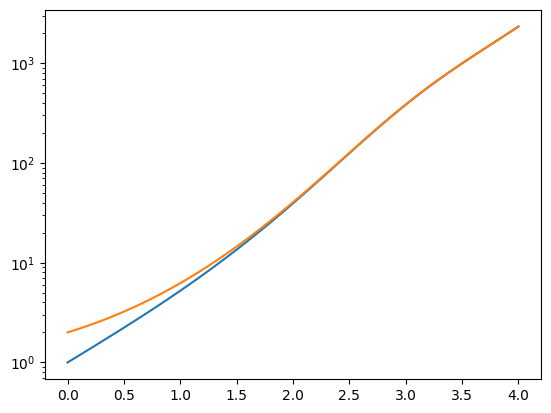

In [30]:
plt.semilogy(xs, inc.scores(xs) / (1.0 - inc.scores(xs)))
plt.semilogy(xs, 1.0 / (1.0 - inc.scores(xs)))

In [31]:
gn = cms_run3.nodes["Global"]

In [32]:
np.sum(get_rejected(gn["contingency"])) / np.sum(get_passed(gn["contingency"]))

102.57191845935351

In [33]:
cms_run3.nodes["Disk"]

{'classifier': <statistics.DummyClassifier at 0x292d7fb80>,
 'error matrix': array([[0., 0.],
        [1., 1.]]),
 'type': 'storage',
 'rejection ratio': 1,
 'data reduction': 1.0,
 'op efficiency': 0.0,
 'sample data': 0,
 'complexity': <function graph.triggers.<locals>.<lambda>(x)>,
 'global ratio': 1,
 'message size': 2000666.6666666667,
 'ops': 2000666.6666666667,
 'contingency': array([[  0.        ,   0.        ],
        [ 76.45921165, 418.29142098]]),
 'discards': array([0., 0.])}

In [34]:
40e6 / np.sum(propagate_statistics(cms_run3, "Disk"))

80848.810212343

In [35]:
cms_run3.edges[("Inner Tracker", "Tracking")]["statistics"]

array([3.9999e+07, 1.0000e+03])

In [36]:
cms_run3.edges[("Tracking", "Intermediate")]["statistics"]

array([3.9999e+07, 1.0000e+03])

In [37]:
cms_run3.nodes["Intermediate"]["discards"]

array([3.99482502e+07, 5.07510505e+02])

In [38]:
em0 = cms_run3.nodes["Tracking"]["error matrix"]

In [16]:
em0

array([[0., 0.],
       [1., 1.]])

In [35]:
get_rejected(cms_run3.nodes["Intermediate"]["error matrix"])

array([0.99872866, 0.50726618])

In [18]:
c0 = cms_run3.edges[("Tracking", "Intermediate")]["statistics"] * em0

In [19]:
get_passed(c0)

array([3.9999e+07, 1.0000e+03])

In [20]:
get_rejected(c0)

array([0., 0.])

In [21]:
np.sum(cms_run3.edges[("Tracking", "Intermediate")]["statistics"]) / np.sum(get_passed(c0))

1.0

In [22]:
cms_run3.edges[("Intermediate", "Global")]["statistics"]

array([50852.48243487,   492.73382413])

In [23]:
#inputs to intermeidate / outputs to global
np.sum(get_passed(c0)) / np.sum(cms_run3.edges[("Intermediate", "Global")]["statistics"])

779.040442603863

In [24]:
np.sum(cms_run3.edges[("Tracking", "Intermediate")]["statistics"]) / np.sum(cms_run3.edges[("Intermediate", "Global")]["statistics"])

779.040442603863

In [33]:
np.sum(cms_run3.edges[("Tracking", "Intermediate")]["statistics"])

40000000.0

In [32]:
np.sum(cms_run3.edges[("Intermediate", "Global")]["statistics"])

51345.216258996894

In [25]:
c0 = cms_run3.nodes["Intermediate"]["classifier"]

In [26]:
c0.threshold

3.0182146090194086

In [27]:
c0.accept(c0.threshold)

0.0025000000451790294

In [28]:
np.sum(cms_run3.edges[("Intermediate", "Global")]["statistics"]) / np.sum(cms_run3.edges[("Global", "Disk")]["statistics"])

103.54435624815429

In [29]:
c = cms_run3.nodes["Global"]["classifier"]

In [30]:
t = c.threshold

In [31]:
c.ratio_fn(t)

100.00000053533613

In [36]:
cms_run3.nodes["Disk"]

{'classifier': <statistics.DummyClassifier at 0x169710a60>,
 'error matrix': array([[0., 0.],
        [1., 1.]]),
 'type': 'storage',
 'rejection ratio': 1,
 'data reduction': 1.0,
 'op efficiency': 0.0,
 'sample data': 0,
 'complexity': <function graph.triggers.<locals>.<lambda>(x)>,
 'message size': 2000666.6666666667,
 'ops': 2000666.6666666667,
 'input rate': 4205695.077485208,
 'message rate': 4205695.077485208,
 'global ratio': 1,
 'contingency': array([[      0.,       0.],
        [4205695., 4205695.]]),
 'energy': 0.0,
 'power': 0.0,
 'discards': array([0., 0.])}

In [38]:
cms_run3.edges[("Global", "Disk")]["statistics"]

array([ 77.13679295, 418.7397388 ])

In [29]:
em1 = cms_run3.nodes["Intermediate"]["error matrix"]

In [23]:
c1 = cms_run3.nodes["Global"]["discards"] * cms_run3.nodes["Global"]["error matrix"]

In [28]:
cms_run3.edges[("Global", "Disk")]["statistics"]

array([1000.0812134 ,  999.99999669])

In [27]:
np.sum(get_passed(c1)) / np.sum(cms_run3.edges[("Global", "Disk")]["statistics"])

0.4950196005199271

In [20]:
cms_run3.nodes["Global"]["discards"]

array([3.99029905e+05, 1.25546267e-07])

In [ ]:
s0 = cms_run3.edges[("Inner Tracker", "Tracking")]["statistics"]

In [26]:
c0 = s0 * cms_run3.nodes["Tracking"]["error matrix"]

In [37]:
s0

array([3.9999e+07, 1.0000e+03])

In [40]:
c0 = s0 * np.array([[0,0],[1,1]]) 

In [41]:
c0[0,:]

array([0., 0.])

In [42]:
c0[1,:]

array([3.9999e+07, 1.0000e+03])

In [27]:
np.diag(c0)

array([3.9999e+07, 1.0000e+03])

In [33]:
np.diag(np.fliplr(c0))

array([0., 0.])

In [13]:
cms_run3.edges[("Intermediate", "Global")]

{'link efficiency': 2.5e-11,
 'message size': 2000666.6666666667,
 'throughput': 20006666666666.668,
 'energy': 0.0004001333333333334,
 'power': 4001.333333333334,
 'statistics': array([[3.73267788e+07, 0.00000000e+00],
        [0.00000000e+00, 9.33192799e+02]])}

In [17]:
inm = cms_run3.edges[("Intermediate", "Global")]["statistics"]

In [18]:
inm

array([[3.73267788e+07, 0.00000000e+00],
       [0.00000000e+00, 9.33192799e+02]])

In [16]:
em = cms_run3.nodes["Global"]["error matrix"]

In [12]:
cms_run3.edges[("Global", "Disk")]

{'link efficiency': 2.5e-11,
 'message size': 2000666.6666666667,
 'throughput': 10003333333333.334,
 'energy': 0.0004001333333333334,
 'power': 2000.666666666667,
 'statistics': array([[3.64775896e+07, 0.00000000e+00],
        [0.00000000e+00, 9.11962539e+02]])}

In [ ]:
cms_run3.graph["op power"] / 1e6

388.8055116520175

In [ ]:
cms_run4  = graph_from_spreadsheet("cms_system_140.xlsx", funcs)

In [ ]:
cms_run4.graph["op power"] / 1e6

4125.291338828952

In [ ]:
cms_run5  = graph_from_spreadsheet("cms_system_200.xlsx", funcs)

In [ ]:
cms_run5.graph["op power"] / 1e6

8921.349737696826

In [ ]:
ns = list(nx.dfs_postorder_nodes(cms_run3, "Inner Tracker"))

In [ ]:
cms_run3

In [ ]:
def calc_rejection(graph: nx.classes.digraph):
    def inner(node):
        downstream = list(nx.dfs_postorder_nodes(graph, node))
        ratios = [graph.nodes[n]["rejection ratio"] for n in downstream]
        total_reduction = functools.reduce(lambda x, y: x * y, ratios)
        graph.nodes[node]["global ratio"] = total_reduction

    list(map(inner, graph.nodes))


In [ ]:
calc_rejection(cms_run3)

In [ ]:
nit = cms_run3.nodes["Inner Tracker"]

In [ ]:
nit["sample rate"] / nit["global ratio"]

1000.0

In [ ]:
year_run3 = 2023
year_run4 = 2028
year_run5 = 2032

In [ ]:
g2 = lean_copy(cms_run3)

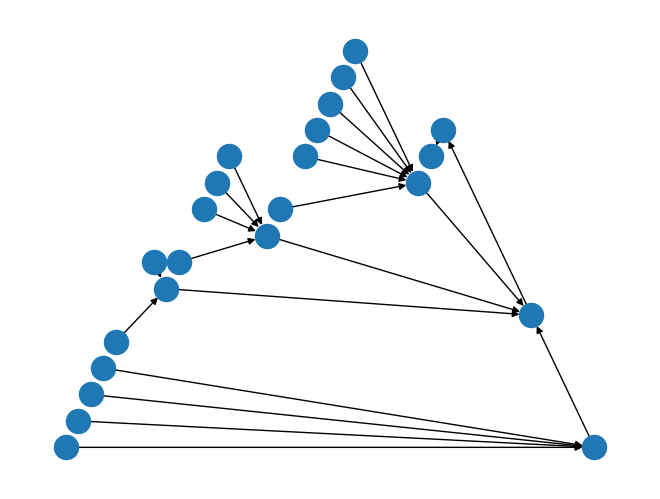

In [ ]:
nx.draw_planar(cms_run3)

In [ ]:
nx.write_gexf(g2, "cms.gexf")

In [ ]:
def predict_demand(baseline, baseline_year, future, future_year):
    intermediate, global_ = processing_resources(baseline, future)
    tech_scale = density_scale_model(future_year) / density_scale_model(baseline_year)
    intermediate /= tech_scale
    global_ /= tech_scale
    return intermediate, global_


In [ ]:
# From TDR 22, chapter 11 (CPU only)
mismatch_cernIT = [1.0, 2.5, 4.9]

In [ ]:
comms_power = np.stack([communication_power(g) for g in (cms_run3, cms_run4, cms_run5,)])

In [ ]:
total_comms_power = np.sum(comms_power, axis=1)

In [ ]:
total_comms_power

array([12418.38280893, 41606.45561251, 58242.05586278])

In [ ]:
comms_demand = total_comms_power / total_comms_power[0]

In [ ]:
comms_demand

array([1.        , 3.35039242, 4.68998716])

In [ ]:
ns = list(nx.dfs_postorder_nodes(cms_run3, "Inner Tracker"))

In [ ]:
ns

['Disk', 'Global', 'Intermediate', 'Tracking', 'Inner Tracker']

In [ ]:
cms_run3.nodes["Inner Tracker"]

1.0

In [ ]:
compare_to_present = lambda x: predict_demand(cms_run3, year_run3, x[0], x[1])

In [ ]:
relative_need = np.stack([compare_to_present(x) for x in [(cms_run3, year_run3), (cms_run4, year_run3), (cms_run5, year_run3) ]])

In [ ]:
# scale of resources needed if no digital scaling
relative_need

array([[ 1.        ,  1.        ],
       [ 3.04548484, 10.61250306],
       [ 4.2110963 , 22.95131897]])

In [ ]:
processing_demand = np.stack([compare_to_present(x) for x in [(cms_run3, year_run3), (cms_run4, year_run4), (cms_run5, year_run5)]])

In [ ]:
#scale of resources with 20% YoY digital scaling
processing_demand

array([[1.        , 1.        ],
       [1.1945769 , 4.1627037 ],
       [0.7812661 , 4.25805684]])

In [ ]:
processing_smartpx = compare_to_present((cms_smartpx, year_run5))

In [ ]:
processing_smartpx

(0.7091577877012747, 1.6844101445095085)

In [ ]:
# convert demand into power

In [ ]:
base_l1t_power = 120e3
base_hlt_power = 1600e3
stage_power = np.array([base_l1t_power, base_hlt_power])

In [ ]:
base_hlt_power_gpu = 1600e3 * (450 / 400)
stage_power_gpu = np.array([base_l1t_power, base_hlt_power_gpu])

In [ ]:
runs = ["CMS Run 3", "CMS Run 4", "CMS Run 5",]

In [ ]:
processing_power = processing_demand * stage_power

In [ ]:
processing_power

array([[ 120000.        , 1600000.        ],
       [ 143349.22782852, 6660325.91537054],
       [  93751.93181552, 6812890.94950966]])

In [ ]:
comms_power

array([[1.23780741e+04, 3.99135512e+01, 3.95183675e-01],
       [4.14791111e+04, 1.21556115e+02, 5.78838642e+00],
       [5.80622222e+04, 1.68079808e+02, 1.17538328e+01]])

In [ ]:
runs_2 = ["No Change", "GPU", "GPU, uLED", "GPU, uLED, Smart Pixel"]

In [ ]:
comms_power_2 = np.stack((communication_power(cms_run5), communication_power(cms_gpu), communication_power_uled(cms_gpu), communication_power_uled(cms_smartpx)))

In [ ]:
comms_power_2

array([[5.80622222e+04, 1.68079808e+02, 1.17538328e+01],
       [5.80622222e+04, 1.68079808e+02, 1.17538328e+01],
       [5.22560000e+03, 1.68079808e+02, 1.17538328e+01],
       [4.72793600e+03, 1.52566590e+02, 1.06689924e+01]])

In [ ]:
#include correction for slightly more GPU than CPU power
predict_demand2 = lambda x: predict_demand(cms_run3, year_run3, x, year_run5) 

In [ ]:
predict_demand2(cms_gpu)

(0.781266098462646, 2.129028405959939)

In [ ]:
processing_demand_2 = np.stack((compare_to_present((cms_run5, year_run5)), predict_demand2(cms_gpu), predict_demand2(cms_gpu), predict_demand2(cms_smartpx)))

In [ ]:
processing_demand_2

array([[0.7812661 , 4.25805684],
       [0.7812661 , 2.12902841],
       [0.7812661 , 2.12902841],
       [0.70915779, 1.68441014]])

In [ ]:
stage_power_gpu

array([ 120000., 1800000.])

In [ ]:
#standard power in run5 prediction, gpu power in other predictions
processing_power_2 = np.concatenate((processing_demand_2[0:1,:] * stage_power, processing_demand_2[1:,:] * stage_power_gpu))

In [ ]:
processing_power_2

array([[  93751.93181552, 6812890.94950966],
       [  93751.93181552, 3832251.13072789],
       [  93751.93181552, 3832251.13072789],
       [  85098.93452415, 3031938.26011712]])

In [ ]:
all_power_2 = np.concatenate((comms_power_2, processing_power_2), axis=1)

In [ ]:
breakdown = pd.DataFrame({
                          "Detector to L1": comms_power[:,0],
                          "L1T": processing_power[:,0],
                          "L1T to HLT": comms_power[:,1],
                          "HLT": processing_power[:,1]})

In [ ]:
frontend_power = np.array([0.0, 0.0, 0.0, 2.34e3])

In [ ]:
breakdown_2 = pd.DataFrame({
                          "Front-End": frontend_power,
                          "Detector to L1": comms_power_2[:,0],
                          "L1T": processing_power_2[:,0],
                          "L1T to HLT": comms_power_2[:,1],
                          "HLT": processing_power_2[:,1]})

In [ ]:
breakdown

,Detector to L1,L1T,L1T to HLT,HLT
0,12378.074074,120000.000000,39.913551,1.600000e+06
1,41479.111111,143349.227829,121.556115,6.660326e+06
2,58062.222222,93751.931816,168.079808,6.812891e+06


In [ ]:
total_power0 = np.sum(breakdown.values, axis=1)

In [ ]:
total_power0

array([1732417.98762526, 6845275.81042515, 6964873.18335516])

In [ ]:
total_power0[2] / total_power0[0]

4.020319133780399

In [ ]:
4.02 * 0.45

1.809

In [ ]:
breakdown_2

,Front-End,Detector to L1,L1T,L1T to HLT,HLT
0,0.0,58062.222222,93751.931816,168.079808,6.812891e+06
1,0.0,58062.222222,93751.931816,168.079808,3.832251e+06
2,0.0,5225.600000,93751.931816,168.079808,3.832251e+06
3,2340.0,4727.936000,85098.934524,152.566590,3.031938e+06


In [ ]:
breakdown.keys()

Index(['Detector to L1', 'L1T', 'L1T to HLT', 'HLT'], dtype='object')

In [ ]:
fig = go.Figure(data = [
    go.Bar(name=k, x=runs, y=breakdown[k]) for k in reversed(breakdown.keys())
])
fig.update_layout(
                  xaxis_title="Experiment",
                  yaxis_title="Total DAQ Power (W)",
                  barmode="stack",
                  width = 900,
                  height = 600,)
fig.show()
fig.write_image("experiment comparison.png")

In [ ]:
from plotly.subplots import make_subplots

In [ ]:
breakdown.iloc[0].values

array([1.23780741e+04, 1.20000000e+05, 3.99135512e+01, 1.60000000e+06])

In [ ]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]], subplot_titles=["Run-3", "Run-4", "Run-5"])

k1 = list(breakdown.keys())
# Add the data to the subplots
fig.add_trace(go.Pie(labels=k1, values=breakdown.iloc[0].values, name='Run 3'), 1, 1)
fig.add_trace(go.Pie(labels=k1, values=breakdown.iloc[1].values, name='Run 4'), 1, 2)
fig.add_trace(go.Pie(labels=k1, values=breakdown.iloc[2].values, name='Run 5'), 1, 3)

# Update the layout of the subplots
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(title_text="Energy Usage Breakdown", width = 800, height = 500)

# Display the subplots
fig.show()
fig.write_image("experiment_pie.png")

In [ ]:
total_power = np.sum(breakdown_2.values, axis=1)

In [ ]:
reduction = total_power / total_power[0]

In [ ]:
reduction

array([1.        , 0.57204679, 0.56446064, 0.44857352])

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

for k in reversed(breakdown_2.keys()):
    fig.add_trace(
        go.Bar(name=k, x=runs_2, y=breakdown_2[k]), secondary_y=False)

fig.add_trace(go.Scatter(x=runs_2, 
            y=reduction, 
            name="Reduction", 
            mode="lines+text", 
            text=[1.0, 0.57, 0.56, 0.45],
            textposition="top center",)
            ,
        secondary_y=True, )

fig.update_layout(
                  xaxis_title="Run-5 Configuration",
                  yaxis_title="Total DAQ Power (W)",
                  barmode="stack",
                  width = 900,
                  height = 600,)

fig.update_yaxes(title_text="Power Reduction", secondary_y=True, range=[0,1.05])
fig.show()
fig.write_image("experiment comparison 2.png")

In [ ]:
breakdown_2

,Front-End,Detector to L1,L1T,L1T to HLT,HLT
0,0.0,58062.222222,93751.931816,168.079808,6.812891e+06
1,0.0,58062.222222,93751.931816,168.079808,3.832251e+06
2,0.0,5225.600000,93751.931816,168.079808,3.832251e+06
3,2340.0,4727.936000,85098.934524,152.566590,3.031938e+06


In [ ]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]], subplot_titles=runs_2[1:])

k2 = list(breakdown_2.keys())
# Add the data to the subplots
fig.add_trace(go.Pie(labels=k2, values=breakdown_2.iloc[1].values, name=runs_2[1]), 1, 1)
fig.add_trace(go.Pie(labels=k2, values=breakdown_2.iloc[2].values, name=runs_2[2]), 1, 2)
fig.add_trace(go.Pie(labels=k2, values=breakdown_2.iloc[3].values, name=runs_2[3]), 1, 3)

# Update the layout of the subplots
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(title_text="Energy Usage Breakdown", width = 800, height = 500)

# Display the subplots
fig.show()
fig.write_image("experiment_pie_2.png")

In [ ]:
#error scores

In [ ]:
from metrics import *

In [ ]:
m = cms_run3.graph["performance"]

In [ ]:
precision(cms_run5.graph["performance"])

0.9271788990825688

In [ ]:
cms_run3.nodes["Intermediate"]["contingency"]

array([[39849625.,    50624.],
       [   50624.,    49126.]])

In [ ]:
m

array([[3.9948239e+07, 5.0773000e+04],
       [1.4900000e+02, 8.3900000e+02]])

In [ ]:
np.sum(m, axis=1)

array([3.9999012e+07, 9.8800000e+02])

In [ ]:
precision(m)

0.8491902834008097

In [ ]:
stop

In [ ]:
"""
Propagate the classification of relevant/irrelevant messages kept and discarded
through the pipeline
"""
def propagate_statistics(graph: nx.classes.digraph, node_name: str):
    node = graph.nodes[node_name]

    #if the node is a detector, begin the error propagation
    if node["type"] == "detector":
        positives = node["sample rate"] / node["global ratio"]
        negatives = node["sample rate"] - positives
        output = np.array([negatives, positives])
        node["discards"] = np.array([0,0])

        return output

    #if it's a processor, recurse through the inputs
    else:
        previous = list(graph.predecessors(node_name))
        n_previous = len(previous)

        #collect statistics over inputs
        statistics = [propagate_statistics(graph, n) for n in previous]
        #store inputs into edges
        edges = [(n, node_name) for n in previous]
        for (i,e) in enumerate(edges):
            graph.edges[e]["statistics"] = statistics[i]
        
        #take the average over the input nodes to collate inputs into a single file
        statistics = functools.reduce(lambda x, y: x + y, statistics) / n_previous
        #obtain results produced through this classifier
        statistics = statistics * node["error matrix"]
        #separate messages discarded & accepted by classifier
        node["discards"] = get_rejected(statistics)
        output = get_passed(statistics)
        
        return output